## PLAN JE NAREDITI OMREŽJE POVEZAV MED IGRALCI IN V KATERIH FILMIH SO IGRALI SKUPAJ

## TODO

***Razmisliti ali naredim actor-actor ali movie-actor***

-actor-actor = vsak node (actor) povezan z drugim katera sta nastopala v vsaj enem filmu skupaj

-movie-actor = dve različni node groups, main so filmi in ostali actors, actor je povezan z filmi v katerih je igral  <- BOLJŠE

## CILJI

-najti igralce ki so bli največkrat skupaj v istih filmi

-najti igralce ki nastopali v vsaj več kot 4 filih kot main actor in s katerimo so najbolj povezani

-


In [72]:
import numpy as np
import pandas as pd 
import networkx as nx
from networkx.algorithms import bipartite
from networkx import NetworkXError
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objs import *
from numpy import random as nprand
import copy

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({
    'figure.figsize': (15, 10),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})
# Seed random number generator

netflix = pd.read_csv("Netflix_all.csv")

subsetMostRatedMovies = netflix[[movie['cast'] != '0' and len(movie['cast'].split(", ")) > 1  for index, movie in netflix.iterrows()]] #Filtrira filme z vsaj 2 ali več igralcev
subsetMostRatedMovies.sort_values(by=['averageRating'], inplace=True, ascending=False)
subset500MostRatedMovies = subsetMostRatedMovies[['type', 'title', 'cast', 'averageRating', 'numVotes']].head(500) #500 najbolj ocenjenih filmov
subset500MostRatedMovies = subset500MostRatedMovies[subset500MostRatedMovies['numVotes'] >= 3000]

In [71]:
topOcenjeniIgralciOcene = dict()
topOcenjeniIgralciStFilmov = dict()

for index, row in netflix.iterrows():
    if(row['type'] == 'Movie' and (row['country'] == 'United States' or row['country'] == 'United Kingdom')):
        cast = row['cast'].split(", ")
        if(len(cast) >= 2):
            for actor in cast:
                if(actor not in topOcenjeniIgralciStFilmov):
                    #topOcenjeniIgralciOcene[actor] = 0
                    topOcenjeniIgralciStFilmov[actor] = 0
                else:
                    #topOcenjeniIgralciOcene[actor] += int(row['averageRating'])
                    topOcenjeniIgralciStFilmov[actor] += 1
           

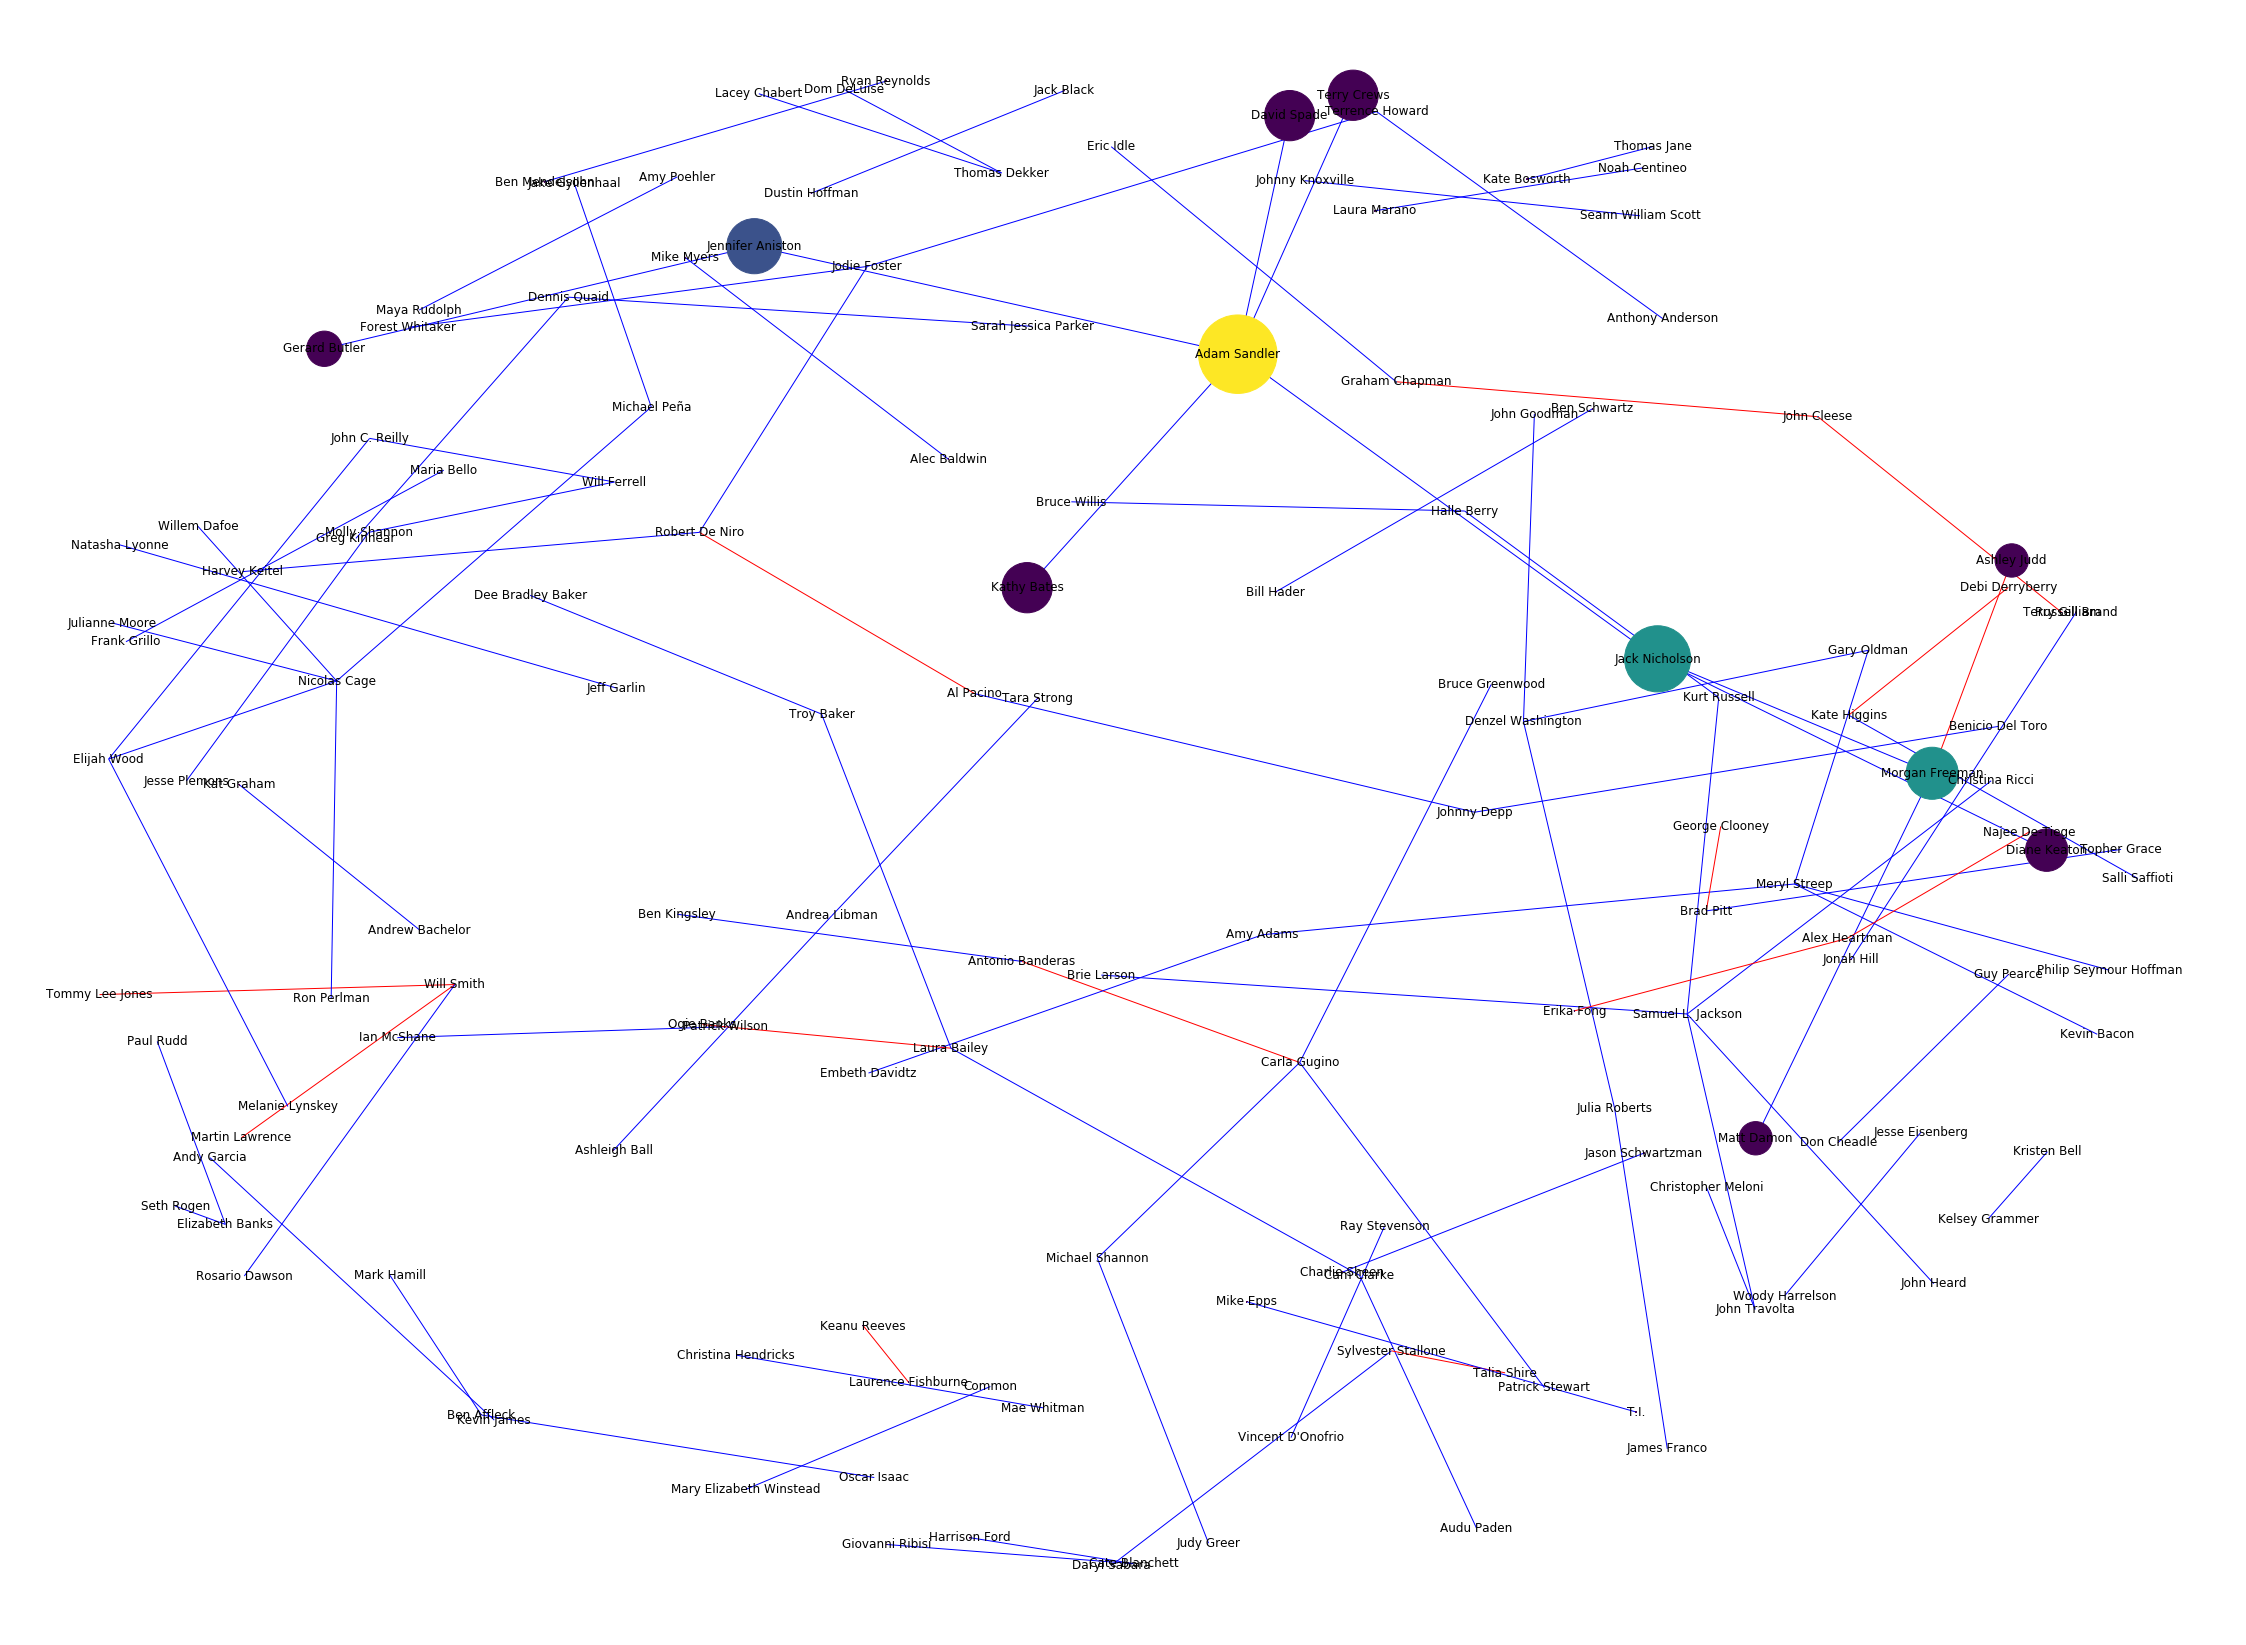

In [73]:
GtopActors = nx.Graph()

for index, row in netflix.iterrows():
    if(row['type'] == 'Movie' and (row['country'] == 'United States' or row['country'] == 'United Kingdom')):
        cast = row['cast'].split(', ')
        if(len(cast) >= 2):
            if(topOcenjeniIgralciStFilmov[cast[0]] >= 3 and topOcenjeniIgralciStFilmov[cast[1]] >= 3):
                #print(G[cast[actor]][cast[actor2]]['weight'])
                if(GtopActors.has_edge(cast[0], cast[1])):
                    wi = GtopActors[cast[0]][cast[1]]['weight']
                    GtopActors[cast[0]][cast[1]]['weight'] = wi + 1                        
                else:
                    GtopActors.add_edge(cast[0], cast[1], weight=1)

plt.figure(figsize=(40, 30))
pos = nx.spring_layout(GtopActors, k=0.70, iterations=100, scale=1.0, center=(0,0))
#pos = nx.random_layout(GtopActors)

betCent = nx.eigenvector_centrality_numpy(GtopActors)
node_size =  [v * 10000 for v in betCent.values()]

node_color = [20000.0 * GtopActors.degree(v) for v in GtopActors]
edge_color = ['blue' if GtopActors.get_edge_data(*v)['weight']<2 else 'red' for v in GtopActors.edges()]

nx.draw_networkx(GtopActors, pos=pos, with_labels=True, node_color=node_color, edge_color=edge_color, node_size=node_size) #For this case choose either draw_spring or draw_kamada_kawai

plt.show()


# OMREŽJE POVEZAV MED IGRALCI IN TEMATIKAMI NA NETFLIXU

## Tip omrežja je theme-actor

    - theme-actor = dve različni node groups, main so tematike in ostali actors, actor je povezan z tematikimi pod katero vsaj eden od filmov/serij v katerih je nastopal spada

## Cilj je najti najbolj raznolike igralce na netflixu, tako rečeno tiste od katerih filmi/serije skupaj so uvrščeni v največ tematik. Prav tako pa najbolj pogoste tematike med le takšnimi igralci.



In [12]:
import numpy as np
import pandas as pd 
import networkx as nx
from networkx.algorithms import bipartite
from networkx import NetworkXError
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objs import *
from numpy import random as nprand
import copy

In [13]:
G_weighted = nx.Graph()
netflix = pd.read_csv("Netflix_all.csv")
genres = set()
actors = set()
for idx, row in netflix.iterrows():
    gen = row['listed_in'].split(", ")
    genres.update(gen)
    act = row['cast'].split(", ")
    actors.update(act)

actors.remove('0')

d = {'actor' : pd.Series(list(actors))}

diverse = pd.DataFrame(d)

for i in genres:
    diverse[i] = 0

diverse = diverse.set_index('actor')

for index, row in netflix.iterrows():
    cast = row['cast'].split(", ")
    gen = row['listed_in'].split(", ")
    for ac in cast:
        if(ac != '0'):
            for ge in gen:
                diverse.loc[ac, ge] = diverse.loc[ac, ge] + 1

for index, row in diverse.iterrows():
    cnt = 0
    for ge in diverse.columns:
        if(diverse.loc[index, ge] != 0):
            cnt = cnt + 1
    if(cnt/len(diverse.columns) < 0.20):
        diverse = diverse.drop(index)

In [14]:
for ind, row in diverse.iterrows():
    for genre in diverse.columns:
        if(diverse.loc[ind, genre] != 0):
            G_weighted.add_edge(ind, genre)
            G_weighted.nodes[ind]["bipartite"] = 0
            G_weighted.nodes[genre]["bipartite"] = 1
            G_weighted[ind][genre]["weight"] = diverse.loc[ind, genre]

G_weighted = G_weighted.subgraph(list(nx.connected_components(G_weighted))[0])

In [15]:
weightsOfEdges = list()
bbbb = list(G_weighted.edges.data('weight', default=1))
for i in bbbb:
    weightsOfEdges.append(i[2])


In [24]:

actors = [v for v in G_weighted.nodes if G_weighted.nodes[v]["bipartite"] == 0]
genres = [v for v in G_weighted.nodes if G_weighted.nodes[v]["bipartite"] == 1]
a = list(G_weighted.edges.data('weight', default=1))
weights = list()
for i in a:
    weights.append(i[2])

listOfDegreesActor = list()
listOfDegreesGenre = list()
max = 0
mostDiverseActor = ''
maxDegree = 0
mostPopularGenre = ''
for v in G_weighted.nodes:
    if(G_weighted.nodes[v]["bipartite"] == 0):
        if(G_weighted.degree[v] > max):
            max = G_weighted.degree[v]
            mostDiverseActor = v
        listOfDegreesActor.append(G_weighted.degree[v])
    elif(G_weighted.nodes[v]["bipartite"] == 1):
        if(G_weighted.degree[v] > maxDegree):
            maxDegree = G_weighted.degree[v]
            mostPopularGenre = v
        listOfDegreesGenre.append(G_weighted.degree[v])
    
print(max)
print(mostDiverseActor)
print(maxDegree)
print(mostPopularGenre)

15
Ron Perlman
280
Dramas


In [25]:
from plotly.offline import plot, iplot
pos = nx.spring_layout(G_weighted, k=0.9)
#d = dict(nx.degree(G_weighted))
Xv=[pos[k][0] for k in actors]
Yv=[pos[k][1] for k in actors]
for i in range(len(actors)):
    actors[i] = actors[i] + ":\n " + str(listOfDegreesActor[i])

Xv2=[pos[k][0] for k in genres]
Yv2=[pos[k][1] for k in genres]
for i in range(len(genres)):
    genres[i] = genres[i] + ":\n " + str(listOfDegreesGenre[i])

Xed=[]
Yed=[]
for edge in G_weighted.edges:
    Xed+=[pos[edge[0]][0],pos[edge[1]][0], None]
    Yed+=[pos[edge[0]][1],pos[edge[1]][1], None]

axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

width=1300
height=1100
layout=Layout(title= "Raznolikost igralcev filmov in serij na netflixu",
    font= dict(size=16),
    showlegend=True,
    autosize=False,
    width=width,
    height=height,
    xaxis=go.layout.XAxis(axis),
    yaxis=go.layout.YAxis(axis),
    margin=go.layout.Margin(
        l=40,
        r=40,
        b=85,
        t=100,
    ),
    hovermode='closest',
    annotations=[
           dict(
           showarrow=False,
            text='Spring layout',
            xref='paper',
            yref='paper',
            x=0,
            y=-0.1,
            xanchor='left',
            yanchor='bottom',
            font=dict(
            size=14
            )
            )
        ]
    )

edgesTrace=Scatter(
               x=Xed,
               y=Yed,
               mode='lines',
               name='Starred in',
               line=dict(color='rgb(210,210,210)', width=1),
               hoverinfo='none'
               
               )
actorsTrace=Scatter(
               x=Xv,
               y=Yv,
               mode='markers',
               name='Actors',
               marker=dict(
                    symbol='diamond',
                    size=[i*1.2 if(i > 12) else 12 for i in listOfDegreesActor], 
                    showscale=False,
                    reversescale = False,                            
                    color= listOfDegreesActor,
                    line=dict(color='rgb(50,50,50)', width=0.5)
               ),
               text=actors,
               hoverinfo='text'
               )
genresTrace=Scatter(
               x=Xv2,
               y=Yv2,
               mode='markers',
               name='Listings',
               marker=dict(symbol='hexagon2',
                    size=[i/4 if(i>150) else (i/3 if(i > 100) else (i/2 if(i > 50) else (20 if(i <= 20) else i))) for i in listOfDegreesGenre],
                    showscale=False,
                    colorscale="Greens",
                    reversescale = False,                            
                    color= listOfDegreesGenre,
                    line=dict(color='rgb(50,50,50)', width=0.5)
               ),
               text=genres,
               hoverinfo='text'
               )

data1=[edgesTrace, actorsTrace, genresTrace, ]
fig1=Figure(data=data1, layout=layout)
fig1.update_layout(legend_title_text='Trend')
fig1.add_annotation(
        x=pos[mostDiverseActor][0],
        y=pos[mostDiverseActor][1],
        xref="x",
        yref="y",
        text="Most Diverse Actor",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=11,
            color="#ffffff"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ff7f0e",
        opacity=0.8
        )
fig1.add_annotation(
        x=pos[mostPopularGenre][0],
        y=pos[mostPopularGenre][1],
        xref="x",
        yref="y",
        text="Most Popular Listing",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=11,
            color="#ffffff"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ff7f0e",
        opacity=0.8
        )
iplot(fig1, filename='diversity_actors_netflix-nx')